# Notebook 1: Exploratory Data Analysis of Movie 25M Dataset

## Introduction

This notebook represents the initial phase of a comprehensive analysis on the "Movie 25M" dataset. We perform a variety of exploratory data analysis (EDA) tasks using PySpark and visualization libraries like Matplotlib and Seaborn.

In this project, we are building a movie recommendation system, an essential tool in the entertainment industry that helps users discover movies that match their preferences. We explore both collaborative filtering and content-based recommendation systems for movie recommendations. Each method has its strengths and is particularly useful in different scenarios.

### Collaborative Filtering

Collaborative filtering is based on the idea that users who agreed in the past will agree in the future about which movies to recommend. This method is powerful when there is ample user interaction data available, allowing the system to identify and leverage patterns in user ratings and preferences effectively.

**Scenario**: For a well-established movie streaming service with a large user base like Netflix, collaborative filtering excels as it can use the rich interaction data to predict and recommend movies that users with similar tastes have liked.

### Content-Based Recommendation

Content-based recommendation systems, on the other hand, recommend movies by analyzing the features of the films themselves, such as genre, director, and plot. This approach is particularly useful when dealing with new users or items, where interaction data might be sparse.

**Scenario**: When a new user joins the platform, the lack of their historical data makes it challenging for collaborative filtering to operate effectively. This is known as the cold start problem. Content-based systems can recommend movies based on the user's initial preferences for movie attributes from the start, circumventing the cold start issue.

### Why Both Are Useful

Integrating both collaborative and content-based systems can harness the strengths of each, leading to a more robust recommendation system. Collaborative filtering offers personalized recommendations based on user similarity, while content-based filtering provides relevant recommendations based on item characteristics, ensuring that users receive well-rounded suggestions even when data from other users is not available.

This hybrid approach not only mitigates the limitations of each method but also enhances overall recommendation quality and user satisfaction.

In [137]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, desc, to_timestamp, year, avg, count, from_unixtime, udf, split,
                                   countDistinct, min, max, mean, explode, month, when)
from pyspark.sql.types import StringType, IntegerType, StructType, StructField
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

## Data Loading and Spark Session Initialization

In [125]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("MovieRatingsAnalysis") \
    .getOrCreate()

In [126]:
# Paths to the datasets
base_path = '/l/users/chaimaa.abi/BigData2/BigData/Dataset/ml-25m/ml-25m'
ratings_path = os.path.join(base_path, 'ratings.csv')
movies_path = os.path.join(base_path, 'movies.csv')

In [127]:
# Read the datasets
ratings = spark.read.csv(ratings_path, header=True, inferSchema=True).selectExpr("cast(userId as int) as user_id", "cast(movieId as int) as movie_id", "cast(rating as double)", "cast(timestamp as int)")
movies = spark.read.csv(movies_path, header=True, inferSchema=True).selectExpr("cast(movieId as int) as movie_id", "title", "genres")

In [128]:
# Show the first few rows of the ratings DataFrame
ratings.show()

+-------+--------+------+----------+
|user_id|movie_id|rating| timestamp|
+-------+--------+------+----------+
|      1|     296|   5.0|1147880044|
|      1|     306|   3.5|1147868817|
|      1|     307|   5.0|1147868828|
|      1|     665|   5.0|1147878820|
|      1|     899|   3.5|1147868510|
|      1|    1088|   4.0|1147868495|
|      1|    1175|   3.5|1147868826|
|      1|    1217|   3.5|1147878326|
|      1|    1237|   5.0|1147868839|
|      1|    1250|   4.0|1147868414|
|      1|    1260|   3.5|1147877857|
|      1|    1653|   4.0|1147868097|
|      1|    2011|   2.5|1147868079|
|      1|    2012|   2.5|1147868068|
|      1|    2068|   2.5|1147869044|
|      1|    2161|   3.5|1147868609|
|      1|    2351|   4.5|1147877957|
|      1|    2573|   4.0|1147878923|
|      1|    2632|   5.0|1147878248|
|      1|    2692|   5.0|1147869100|
+-------+--------+------+----------+
only showing top 20 rows



In [129]:
# Show the first few rows of the movies DataFrame
movies.show(5)

+--------+--------------------+--------------------+
|movie_id|               title|              genres|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Adventure|Animati...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|Comedy|Drama|Romance|
|       5|Father of the Bri...|              Comedy|
+--------+--------------------+--------------------+
only showing top 5 rows



## Descriptive Statistics

In [130]:
# Basic Descriptive Statistics
total_users = ratings.select("user_id").distinct().count()
total_movies = movies.select("movie_id").distinct().count()
total_ratings = ratings.count()

# Execute and show results
print("Total Users:", total_users)
print("Total Movies:", total_movies)
print("Total Ratings:", total_ratings)


Total Users: 162541
Total Movies: 62423
Total Ratings: 25000095


In [131]:
# Rating
ratings_distribution = ratings.groupBy("rating").count().withColumn("Percentage", (col("count") / total_ratings) * 100)

# Movie Details
number_of_genres = movies.select(explode(split("genres", "\\|")).alias("genre")).distinct().count()
avg_genres_per_movie = movies.select("movie_id", explode(split("genres", "\\|")).alias("genre")).groupBy("movie_id").agg(countDistinct("genre").alias("number_of_genres")).agg(mean("number_of_genres").alias("Average Genres Per Movie"))
genre_distribution = movies.withColumn("genre", explode(split(col("genres"), "\\|"))).groupBy("genre").count().orderBy(desc("count"))

# User Engagement
user_engagement_stats = ratings.groupBy("user_id").count().agg(max("count").alias("Max Ratings by User"), min("count").alias("Min Ratings by User"), mean("count").alias("Average Ratings by User"))
user_ratings_distribution = ratings.groupBy("user_id").count().groupBy("count").count().orderBy(desc("count"))

# Temporal Dynamics (assuming 'timestamp' is in UNIX time format and needs to be converted to human-readable format first)
ratings_by_year = ratings.withColumn("year", year(from_unixtime("timestamp"))).groupBy("year").count().orderBy("year")
ratings_by_month = ratings.withColumn("month", month(from_unixtime("timestamp"))).groupBy("month").count().orderBy("month")

# Missing Data
missing_data_percentage = movies.select([(count(when(col(c).isNull(), c)) / count("*")).alias(c + "_missing") for c in movies.columns]).collect()



ratings_distribution.show()
print("Number of Genres:", number_of_genres)
avg_genres_per_movie.show()
genre_distribution.show()
user_engagement_stats.show()
user_ratings_distribution.show()
ratings_by_year.show()
ratings_by_month.show()
for row in missing_data_percentage:
    print(row)


+------+-------+------------------+
|rating|  count|        Percentage|
+------+-------+------------------+
|   3.5|3177318| 12.70922370494992|
|   4.5|2200539| 8.802122551934302|
|   2.5|1262797| 5.051168805558539|
|   1.0| 776815| 3.107248192456869|
|   4.0|6639798| 26.55909107545391|
|   0.5| 393068|1.5722660253891036|
|   3.0|4896928|19.587637566977246|
|   2.0|1640868|6.5634470589011755|
|   1.5| 399490|1.5979539277750743|
|   5.0|3612474|14.449841090603854|
+------+-------+------------------+

Number of Genres: 20
+------------------------+
|Average Genres Per Movie|
+------------------------+
|      1.7991285263444563|
+------------------------+

+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama|25606|
|            Comedy|16870|
|          Thriller| 8654|
|           Romance| 7719|
|            Action| 7348|
|            Horror| 5989|
|       Documentary| 5605|
|             Crime| 5319|
|(no genres listed)| 5062|
|         Adve

+-------------------+-------------------+-----------------------+
|Max Ratings by User|Min Ratings by User|Average Ratings by User|
+-------------------+-------------------+-----------------------+
|              32202|                 20|     153.80793153727367|
+-------------------+-------------------+-----------------------+



+-----+-----+
|count|count|
+-----+-----+
|32202|    1|
| 9178|    1|
| 8913|    1|
| 7919|    1|
| 7488|    1|
| 6647|    1|
| 6564|    1|
| 6553|    1|
| 5693|    1|
| 5649|    1|
| 5633|    1|
| 5525|    1|
| 5276|    1|
| 5244|    1|
| 5219|    1|
| 5160|    1|
| 5066|    1|
| 5045|    1|
| 4861|    1|
| 4831|    1|
+-----+-----+
only showing top 20 rows



+----+-------+
|year|  count|
+----+-------+
|1995|      3|
|1996|1429908|
|1997| 626267|
|1998| 272113|
|1999|1058033|
|2000|1735618|
|2001|1057946|
|2002| 777824|
|2003| 920554|
|2004|1047823|
|2005|1613039|
|2006|1039020|
|2007| 931322|
|2008|1018351|
|2009| 809882|
|2010| 792795|
|2011| 676408|
|2012| 635164|
|2013| 515671|
|2014| 478412|
+----+-------+
only showing top 20 rows



+-----+-------+
|month|  count|
+-----+-------+
|    1|2210670|
|    2|1854184|
|    3|2138483|
|    4|1920198|
|    5|2018262|
|    6|1980210|
|    7|2178398|
|    8|2070386|
|    9|1796100|
|   10|2143768|
|   11|2445570|
|   12|2243866|
+-----+-------+

Row(movie_id_missing=0.0, title_missing=0.0, genres_missing=0.0)


## Visualization

Several visualizations are created to better understand the data:
1. **Rating Distribution**: Bar plot of the distribution of ratings.
2. **Ratings Over Time**: Line plot of average rating over time.
3. **Most Popular Movies**: Bar plot of the most frequently rated movies.
4. **Highest Rated Movies**: Bar plot of movies with the highest average rating, considering movies with at least 50 ratings.
5. **Population vs. Rating**: Scatter plot showing the relationship between the average rating and the number of ratings for movies.

In [134]:
base_path = '/l/users/chaimaa.abi/BigData2/BigData/assets'

# Custom function to adjust palette intensity
def adjust_palette(palette_name, start=0.0, stop=1.0, n_colors=256):
    full_palette = sns.color_palette(palette_name, n_colors=n_colors)
    adjusted_palette = full_palette[int(start*n_colors):int(stop*n_colors)]
    return adjusted_palette if adjusted_palette else [full_palette[-1]]  # Ensure there's always at least one color

# 1. Rating Distribution
"""This function plots the distribution of ratings.
We'll use PySpark to compute the count of each rating and then convert to a Pandas DataFrame for plotting."""
def plot_rating_distribution(ratings_df, filename):
    rating_counts = ratings_df.groupBy("rating").count().toPandas()
    plt.figure(figsize=(10, 6))
    sns.barplot(x='rating', y='count', data=rating_counts, palette=adjust_palette("Blues_d", start=0.0, stop=0.5))
    # plt.title('Distribution of Ratings', fontsize=16)
    # plt.xlabel('Rating', fontsize=14)
    # plt.ylabel('Count', fontsize=14)
    sns.despine()
    plt.savefig(os.path.join(base_path, filename))
    plt.show()


# 2. Ratings Over Time
"""This function calculates and plots the average rating over time. You'll need to ensure timestamps
are handled correctly within PySpark."""
def plot_ratings_over_time(ratings_df, filename):
    ratings_by_year = ratings_df.withColumn("year", year(from_unixtime("timestamp")))
    yearly_average = ratings_by_year.groupBy("year").agg(avg("rating").alias("avg_rating")).orderBy("year").toPandas()
    plt.figure(figsize=(12, 6))
    color = adjust_palette("Blues_d", start=0.5, stop=1.0)  # Get adjusted palette
    plt.plot(yearly_average['year'], yearly_average['avg_rating'], marker='o', linestyle='-', color=color[len(color)//2])
    # plt.title('Average Rating Over Time', fontsize=16)
    # plt.xlabel('Year', fontsize=14)
    # plt.ylabel('Average Rating', fontsize=14)
    plt.grid(True)
    plt.savefig(os.path.join(base_path, filename))
    plt.show()

# 3. Most Popular Movies
"""For the most popular movies, count occurrences in PySpark and then plot."""
def plot_most_popular_movies(movies_df, filename, top_n=10):
    popular_movies = movies_df.groupBy("title").count().orderBy("count", ascending=False).limit(top_n).toPandas()
    plt.figure(figsize=(20, 16))
    sns.barplot(x='count', y='title', data=popular_movies, palette=adjust_palette("Blues_d", start=0.2, stop=0.7))
    # plt.title('Top 10 Most Rated Movies', fontsize=16)
    # plt.xlabel('Number of Ratings', fontsize=14)
    # plt.ylabel('Movies', fontsize=14)
    sns.despine()
    plt.savefig(os.path.join(base_path, filename))
    plt.show()

# 4. Highest Rated Movies
"""Compute statistics in PySpark, ensuring filtering is also done in Spark to leverage
its distributed processing capabilities."""
def plot_highest_rated_movies(ratings_df, filename, top_n=10, min_ratings=50):
    movie_stats = ratings_df.groupBy("title").agg(count("rating").alias("count"), avg("rating").alias("mean"))
    movie_stats = movie_stats.filter(movie_stats["count"] >= min_ratings)
    highest_rated = movie_stats.orderBy("mean", ascending=False).limit(top_n).toPandas()
    plt.figure(figsize=(20, 16))
    sns.barplot(x='mean', y='title', data=highest_rated, palette=adjust_palette("Blues_d", start=0.3, stop=0.8))
    # plt.title('Top 10 Highest Rated Movies (min 50 ratings)', fontsize=16)
    # plt.xlabel('Average Rating', fontsize=14)
    # plt.ylabel('Movies', fontsize=14)
    sns.despine()
    plt.savefig(os.path.join(base_path, filename))
    plt.show()

# 5. Population vs. Rating
"""Use PySpark for the heavy lifting and then switch to Pandas for plotting."""
def plot_mean_rating_vs_number_of_ratings(ratings_df, filename):
    agg_ratings = ratings_df.groupBy('title').agg(avg('rating').alias('mean_rating'), count('rating').alias('number_of_ratings'))
    agg_ratings_GT100 = agg_ratings.filter("number_of_ratings > 100").toPandas()
    plt.figure(figsize=(10, 6))
    sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100, kind="scatter", palette=adjust_palette("Blues_d", start=0.1, stop=0.6), edgecolor="white", s=100, alpha=0.6)
    # sns.jointplot(data=agg_ratings_GT100, kind="scatter", palette=adjust_palette("Blues_d", start=0.1, stop=0.6), edgecolor="white", s=100, alpha=0.6)
    # plt.suptitle('Relationship Between Average Rating and Number of Ratings', fontsize=16)
    plt.savefig(os.path.join(base_path, filename))
    plt.show()


/tmp/slurm-chaimaa.abi-29605/ipykernel_2988532/1739671452.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='count', data=rating_counts, palette=adjust_palette("Blues_d", start=0.0, stop=0.5))
/tmp/slurm-chaimaa.abi-29605/ipykernel_2988532/1739671452.py:15: UserWarning: The palette list has more values (128) than needed (10), which may not be intended.
  sns.barplot(x='rating', y='count', data=rating_counts, palette=adjust_palette("Blues_d", start=0.0, stop=0.5))


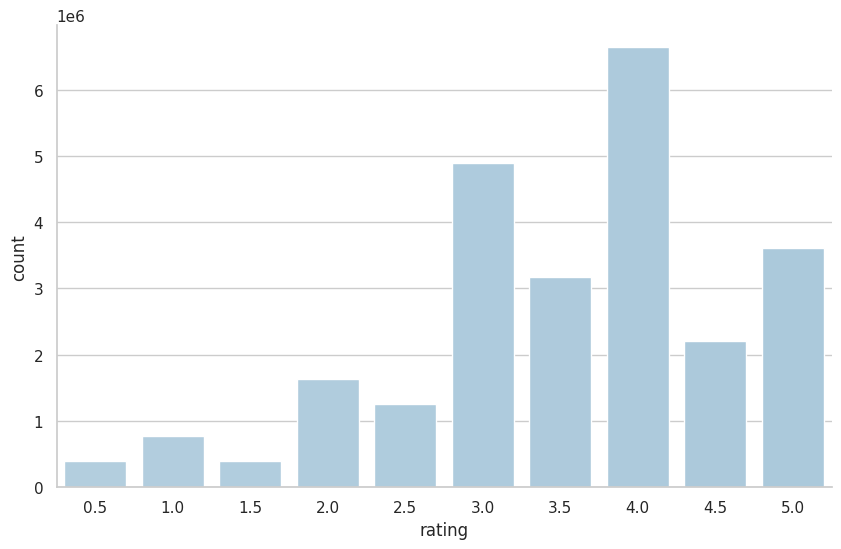

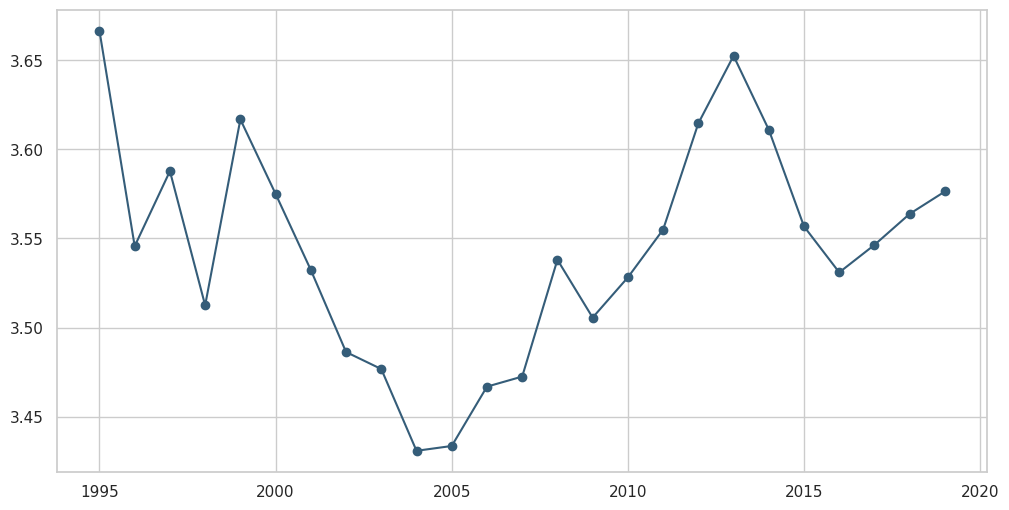

/tmp/slurm-chaimaa.abi-29605/ipykernel_2988532/1739671452.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='title', data=popular_movies, palette=adjust_palette("Blues_d", start=0.2, stop=0.7))
/tmp/slurm-chaimaa.abi-29605/ipykernel_2988532/1739671452.py:45: UserWarning: The palette list has more values (128) than needed (10), which may not be intended.
  sns.barplot(x='count', y='title', data=popular_movies, palette=adjust_palette("Blues_d", start=0.2, stop=0.7))


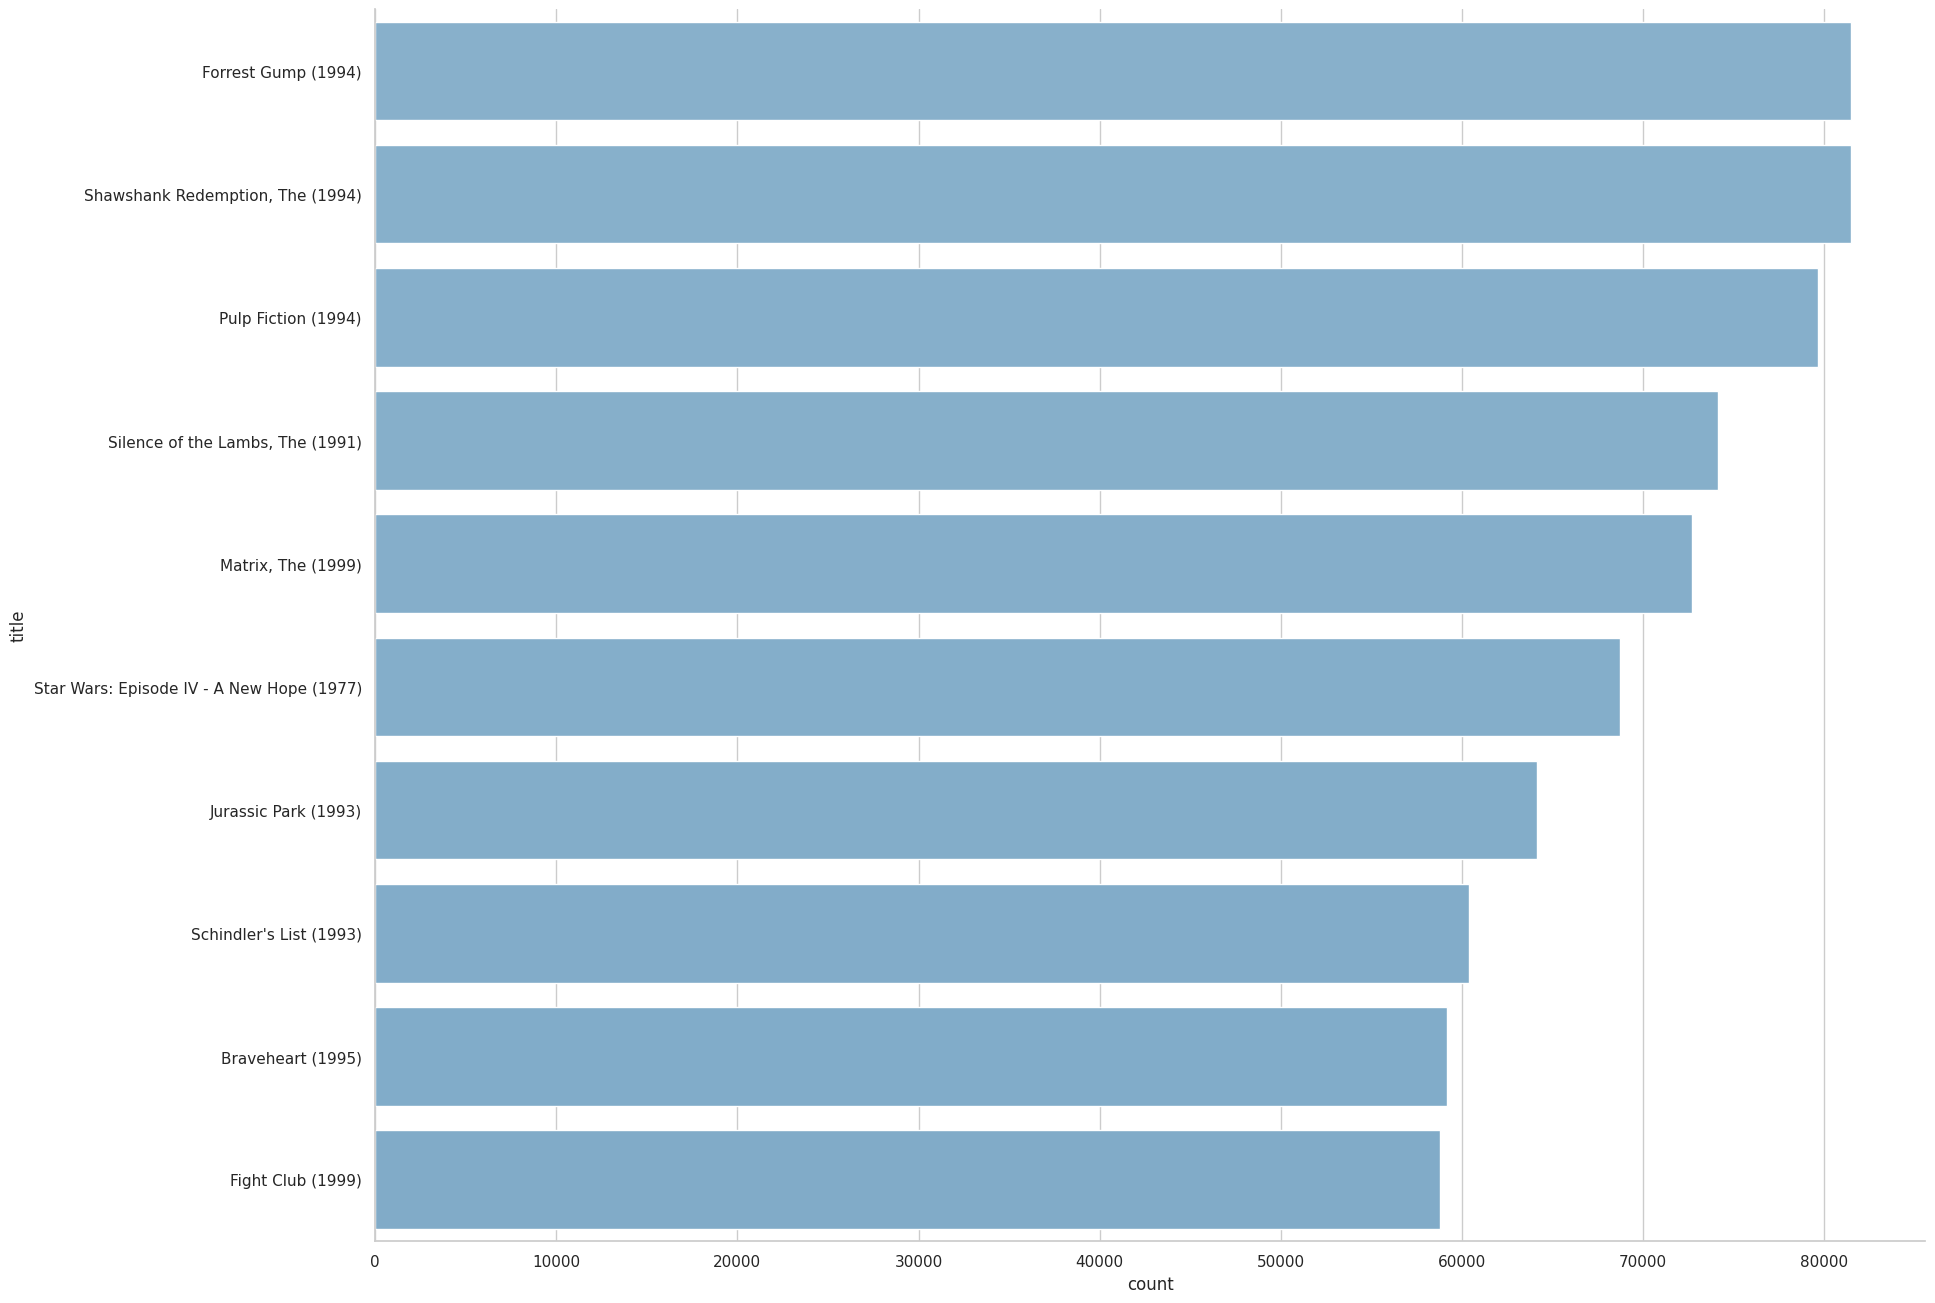

/tmp/slurm-chaimaa.abi-29605/ipykernel_2988532/1739671452.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean', y='title', data=highest_rated, palette=adjust_palette("Blues_d", start=0.3, stop=0.8))
/tmp/slurm-chaimaa.abi-29605/ipykernel_2988532/1739671452.py:61: UserWarning: The palette list has more values (128) than needed (10), which may not be intended.
  sns.barplot(x='mean', y='title', data=highest_rated, palette=adjust_palette("Blues_d", start=0.3, stop=0.8))


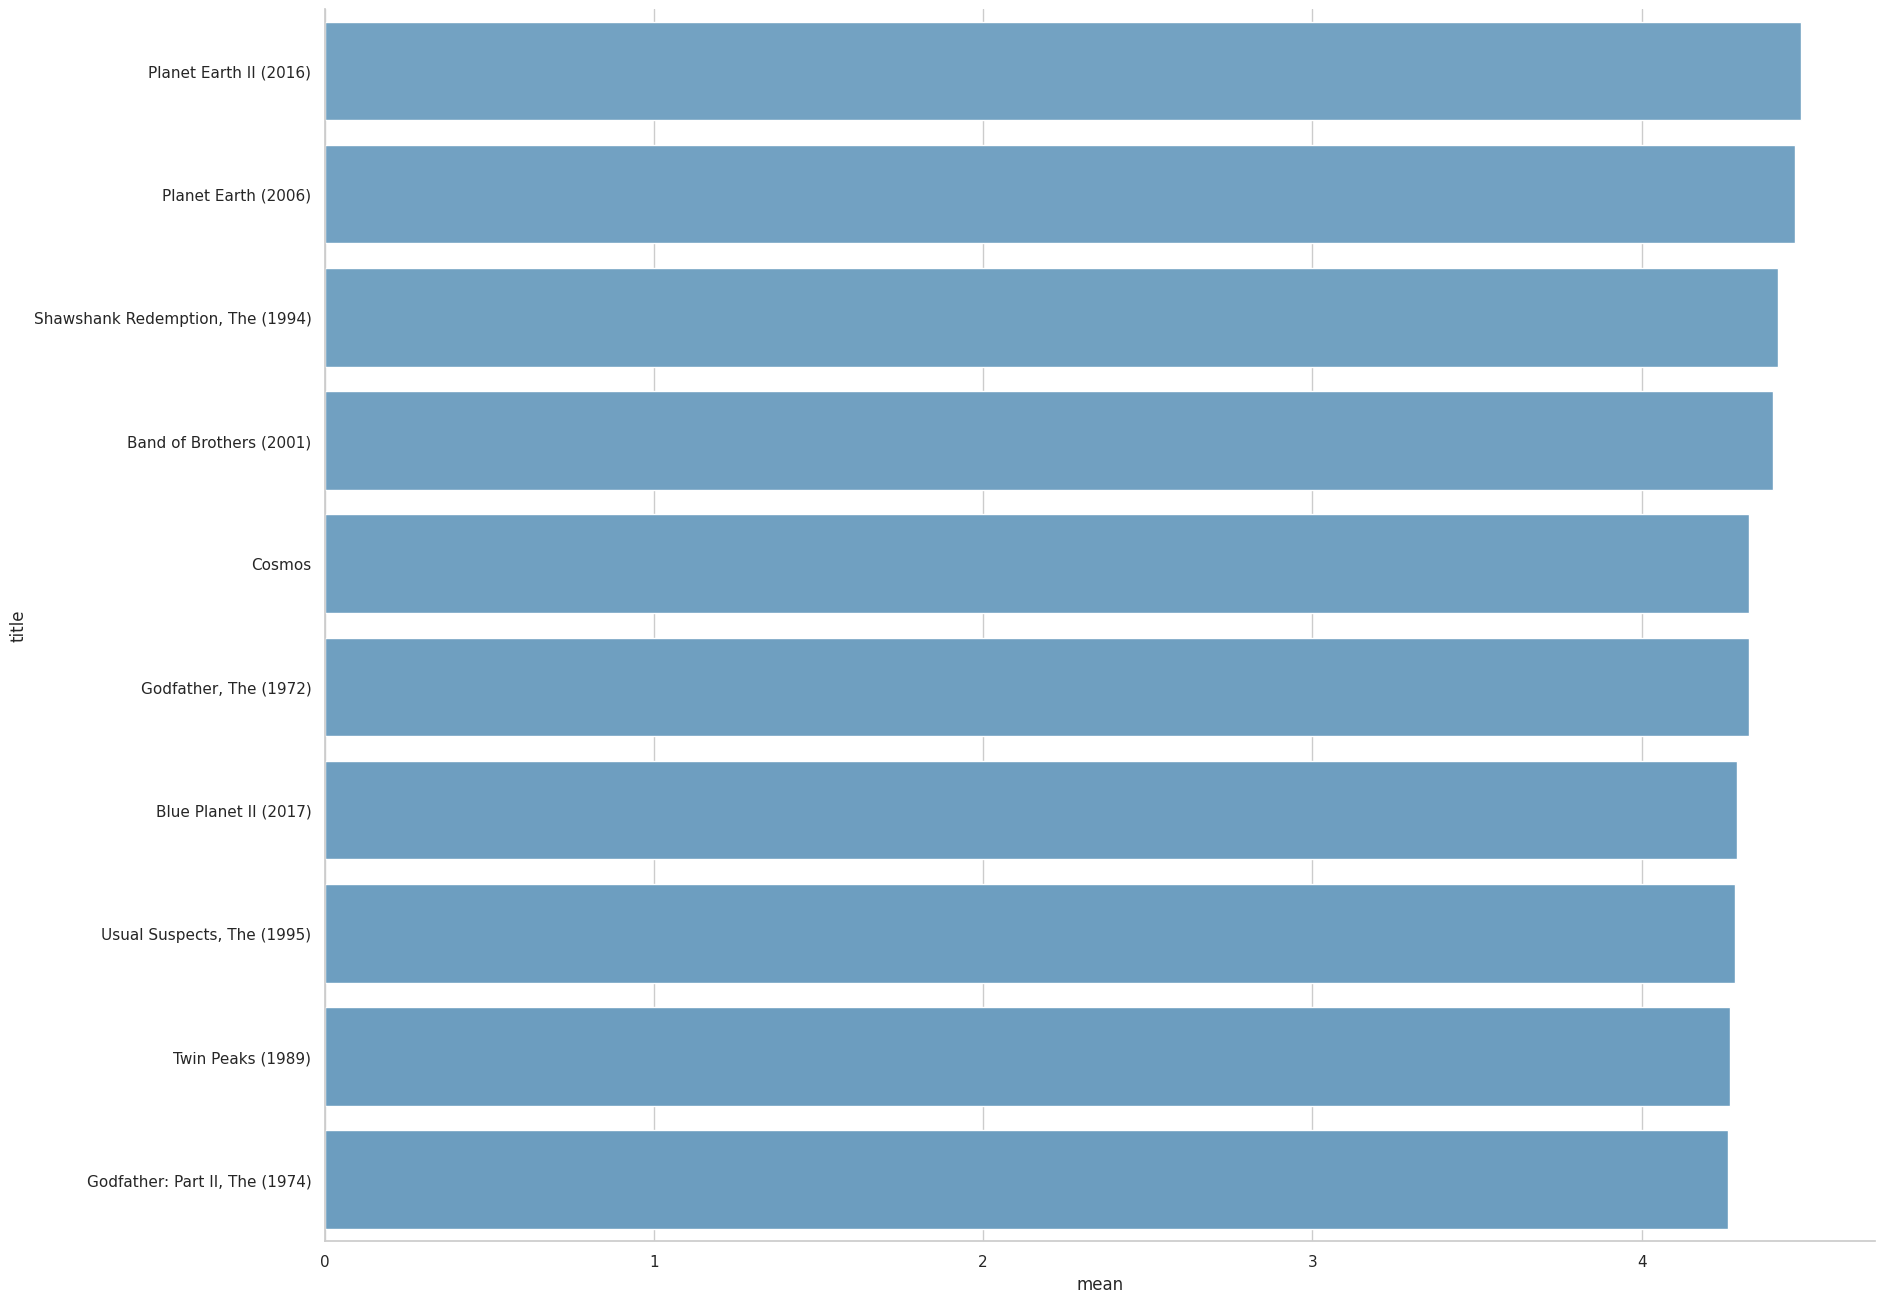

<Figure size 1000x600 with 0 Axes>

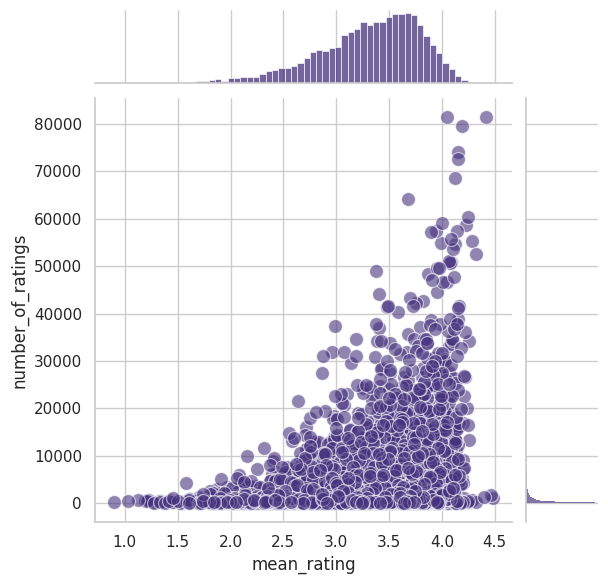

In [135]:
# Example usage, assuming 'merged_data' is a Spark DataFrame loaded with the appropriate schema
plot_rating_distribution(merged_data, 'rating_distribution.png')
plot_ratings_over_time(merged_data, 'ratings_over_time.png')
plot_most_popular_movies(merged_data, 'most_popular_movies.png', 10)
plot_highest_rated_movies(merged_data, 'highest_rated_movies.png', 10, 50)
plot_mean_rating_vs_number_of_ratings(merged_data, 'rating_vs_population.png')

In [136]:
# Stop the Spark session
spark.stop()

## Conclusion

This notebook sets the stage for deeper analysis in subsequent notebooks:
- **Notebook 2**: Implementation of Collaborative Filtering.
- **Notebook 3**: Implementation of Content-Based Filtering.